# Summary

We're interested in GitHub project health. I first establish a baseline
using known successful projects and projects which were previously successful
but have now been retired. This notebook is intended to get the basic working
thing together then we can scale up later.

# Objective function:

Lines of code is a good indicator but we don't want to 
just reward increasing project complexity. I want to
equally reward code additions and deletions so we'll
use the [Manhattan Norm](https://en.wikipedia.org/wiki/Taxicab_geometry)
or $l_1$ distance.

$$
||x||_1 := \sum_{i=1}^n |x_i|.
$$

We want to maximize the $l_1$ distance so we can define
the cost function $c(x)$ as

$$
c(x) = -\sum_{i=1}^n |x_i|
$$

which means we want to now minimize $c(x)$.


## Dependencies

In [57]:
import os
from urllib.parse import urljoin

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from okra.models import (Meta, Author, Contrib, CommitFile, Info)
from okra.models import DataAccessLayer
from okra.playbooks import local_persistance
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sqlalchemy import func

%matplotlib inline

## Prepare Data

In [58]:
DATA = "/Users/tylerbrown/code/"
repos = [
    "torvalds/linux",
    "docker/docker-ce",
    'apache/attic-lucy',
    'apache/attic-wink',
    'apache/spark',
    'apache/lucene-solr'
]

In [59]:
# Persist repo info in database

for repo_name in repos:
    local_persistance(repo_name, DATA)

Issue with row 0, repo '/Users/tylerbrown/code/torvalds/linux'
Issue with row 0, repo '/Users/tylerbrown/code/docker/docker-ce'
Issue with row 0, repo '/Users/tylerbrown/code/apache/attic-lucy'
Issue with row 0, repo '/Users/tylerbrown/code/apache/attic-wink'
Issue with row 0, repo '/Users/tylerbrown/code/apache/spark'
Issue with row 0, repo '/Users/tylerbrown/code/apache/lucene-solr'


In [60]:
repodbs = {i : i.replace("/", "__REPODB__") + ".db" for i in repos}
repodbs

{'torvalds/linux': 'torvalds__REPODB__linux.db',
 'docker/docker-ce': 'docker__REPODB__docker-ce.db',
 'apache/attic-lucy': 'apache__REPODB__attic-lucy.db',
 'apache/attic-wink': 'apache__REPODB__attic-wink.db',
 'apache/spark': 'apache__REPODB__spark.db',
 'apache/lucene-solr': 'apache__REPODB__lucene-solr.db'}

# Exploratory Analysis: Linux Kernel

Trying to get an idea of which features would be informative
by exploring the Linux kernel. Some initial thoughts about
repo health indicators

1. Number of commits per time period
1. Number of developers per time period


In [61]:
conn_string = "sqlite:///" + urljoin(DATA, repodbs['torvalds/linux'])

In [62]:
dal = DataAccessLayer(conn_string)
dal.connect()
dal.session = dal.Session()

### Compute objective function per month

Let's start by computing our objective function
once per month. 

In [63]:
q1 = dal.session.query(
    Meta.commit_hash, Author.authored, CommitFile.lines_added, CommitFile.lines_deleted
).join(Author).join(CommitFile)

In [64]:
items = []
for item in q1.all():
    r = {
        "commit_hash": item.commit_hash,
        "date_authored": item.authored,
        "lines_added": item.lines_added,
        "lines_deleted": item.lines_deleted
    }
    items.append(r)
objdf = pd.DataFrame(items)
objdf.shape

(1824726, 4)

In [65]:
per = objdf.date_authored.dt.to_period("M")

In [66]:
ok = objdf.groupby(per).sum()

In [67]:
ok['costfunc'] = -np.sqrt(np.square(ok.lines_added.values) + np.square(ok.lines_deleted.values))

In [68]:
ok.head()

,lines_added,lines_deleted,costfunc
date_authored,,,
1970-01,2,1,-2.236068
2001-09,145,48,-152.738338
2002-04,2272,632,-2358.263768
2003-02,56,55,-78.492038
2004-07,9,0,-9.000000


### Check features against cost function

In [69]:
# Number of commits per time period
q2 = dal.session.query(
    Meta.commit_hash, Info.created
).join(Info)

items = []
for item in q2.all():
    r = {
        "commit_hash" : item.commit_hash,
        "date_created" : item.created,
    }
    items.append(r)
comdf = pd.DataFrame(items)

In [70]:
per = comdf.date_created.dt.to_period('M')
comdf.shape

(824976, 2)

In [71]:
comct = comdf.groupby(per).count()

In [72]:
comct.head()

,commit_hash,date_created
date_created,,
1970-01,1,1
2001-09,2,2
2002-04,12,12
2003-02,1,1
2004-07,1,1


In [73]:
# Number of developers per time period

q3 = dal.session.query(
    Meta.commit_hash, Author.name, Author.email, 
    Author.authored
).join(Author)

items = []
for item in q3.all():
    r = {
        "commit_hash": item.commit_hash,
        "author_name": item.name,
        "author_email": item.email,
        "author_date": item.authored,
    }
    items.append(r)
authordf = pd.DataFrame(items)

In [74]:
authordf.shape

(824976, 4)

In [75]:
per = authordf.author_date.dt.to_period('M')

In [76]:
authct = authordf[['author_name','author_email']].groupby(per).count()

In [77]:
authct.head()

,author_name,author_email
author_date,,
1970-01,1,1
2001-09,2,2
2002-04,12,12
2003-02,1,1
2004-07,1,1


## Initial predictive model

In [78]:
print("y: {}, commits: {}, author: {}".format(ok.shape, comct.shape, authct.shape))

y: (183, 3), commits: (183, 2), author: (183, 2)


In [79]:
df = ok.join(comct).join(authct)

In [80]:
df.head()

,lines_added,lines_deleted,costfunc,commit_hash,date_created,author_name,author_email
date_authored,,,,,,,
1970-01,2,1,-2.236068,1,1,1,1
2001-09,145,48,-152.738338,2,2,2,2
2002-04,2272,632,-2358.263768,12,12,12,12
2003-02,56,55,-78.492038,1,1,1,1
2004-07,9,0,-9.000000,1,1,1,1


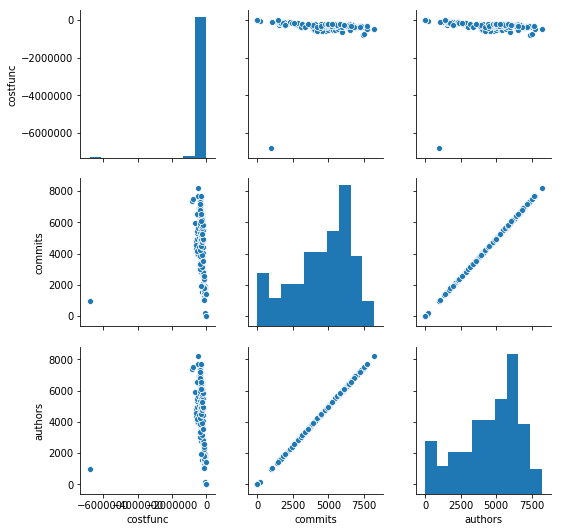

In [81]:
data = df[['costfunc', 'commit_hash', 'author_name']]
data.columns = ['costfunc', 'commits', 'authors']
sns.pairplot(data)
plt.show()

In [82]:
data.describe()

,costfunc,commits,authors
count,1.830000e+02,183.000000,183.000000
mean,-3.225717e+05,4508.065574,4508.065574
std,5.021419e+05,2119.350172,2119.350172
min,-6.794630e+06,1.000000,1.000000
25%,-3.615016e+05,3166.000000,3166.000000
50%,-2.895008e+05,4962.000000,4962.000000
75%,-2.200318e+05,6169.500000,6169.500000
max,-1.414214e+00,8202.000000,8202.000000


It looks like `commits` and `authors` are almost perfectly correlated
so there's no reason to use both features. There also appears to be
an instance of a strong outlier in the `costfunc`. Let's try to predict
using a Ridge Regression and one feature. 

In [83]:
data_dropoutliers = data[data.costfunc > -500000]

In [84]:
data.shape

(183, 3)

In [85]:
data_dropoutliers.shape

(167, 3)

In [86]:
data_dropoutliers.describe()

,costfunc,commits,authors
count,167.000000,167.000000,167.000000
mean,-260558.345094,4443.161677,4443.161677
std,116334.779914,2158.053243,2158.053243
min,-491590.509291,1.000000,1.000000
25%,-337389.687224,3077.500000,3077.500000
50%,-284437.946317,4962.000000,4962.000000
75%,-210811.308781,6169.500000,6169.500000
max,-1.414214,8202.000000,8202.000000


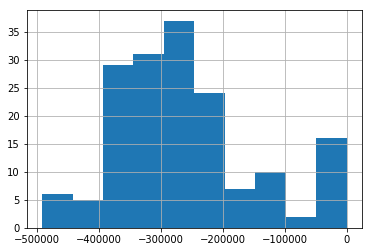

In [87]:
data_dropoutliers.costfunc.hist()

In [88]:
X = data_dropoutliers.authors
y = data_dropoutliers.costfunc

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [90]:
X_train.shape

(133,)

In [91]:
X_train = np.reshape(X_train.values, (-1, 1))
y_train = np.reshape(y_train.values, (-1, 1))

In [92]:
X_test = np.reshape(X_test.values, (-1, 1))
y_test = np.reshape(y_test.values, (-1, 1))

In [93]:
# Ridge regression

reg01 = linear_model.RidgeCV(alphas=[10.0, 100.0, 1000.0], cv=3)

In [94]:
reg01.fit(X_train, y_train)

RidgeCV(alphas=array([  10.,  100., 1000.]), cv=3, fit_intercept=True,
    gcv_mode=None, normalize=False, scoring=None, store_cv_values=False)

In [95]:
reg01.score(X_test, y_test)

0.5056594759539264

In [96]:
y_pred = reg01.predict(y_test)

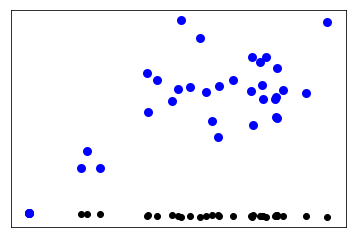

In [97]:
plt.scatter(X_test, y_test, color='black')
plt.scatter(X_test, y_pred, color='blue', linewidth=3)
plt.xticks(())
plt.yticks(())

plt.show()

In [98]:
reg02 = linear_model.LinearRegression()

In [99]:
reg02.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [100]:
reg02.score(X_test, y_test)

0.5056594337183401

In [101]:
y_pred = reg02.predict(y_test)

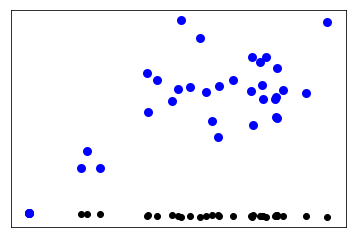

In [102]:
plt.scatter(X_test, y_test, color='black')
plt.scatter(X_test, y_pred, color='blue', linewidth=3)
plt.xticks(())
plt.yticks(())

plt.show()

In [103]:
reg1 = DecisionTreeRegressor(max_depth=2)
reg2 = DecisionTreeRegressor(max_depth=5)
reg3 = DecisionTreeRegressor(max_depth=10)

In [104]:
reg1.fit(X_train, y_train)
reg2.fit(X_train, y_train)
reg3.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=10, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [105]:
y_01 = reg01.predict(X_test)
y_02 = reg02.predict(X_test)
y_1 = reg1.predict(X_test)
y_2 = reg2.predict(X_test)
y_3 = reg3.predict(X_test)

In [106]:
reg01.score(X_test, y_test)

0.5056594759539264

In [107]:
reg02.score(X_test, y_test)

0.5056594337183401

In [108]:
reg1.score(X_test, y_test)

0.693577511195867

In [109]:
reg2.score(X_test, y_test)

0.6726092363387366

In [110]:
reg3.score(X_test, y_test)

0.625826708861733

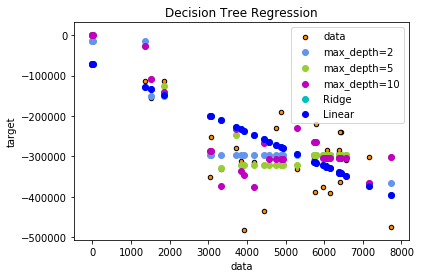

In [111]:
# Plot the results
plt.figure()
plt.scatter(X_test, y_test, s=20, edgecolor="black",
            c="darkorange", label="data")
plt.scatter(X_test, y_1, color="cornflowerblue",
         label="max_depth=2")
plt.scatter(X_test, y_2, color="yellowgreen", label="max_depth=5")
plt.scatter(X_test, y_3, color='m', label='max_depth=10')
plt.scatter(X_test, y_01, color='c', label='Ridge')
plt.scatter(X_test, y_02, color='b', label='Linear')
plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()

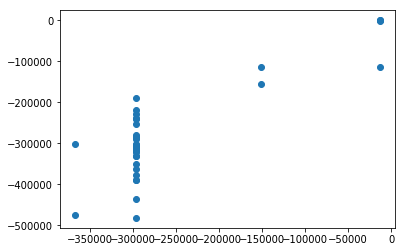

In [112]:
plt.scatter(np.reshape(y_1, (-1,1)), y_test)

## Better time series approach

Those models performed kind of terribly. Let's see
if we can dig more into the time series and do something
better.

In [125]:
data.shape

(183, 3)

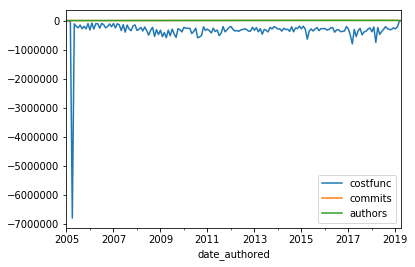

In [135]:
data[(data.index >= '2005-01') & (data.index < '2020-01')].plot()
plt.show()

We can see that there really isn't a clear relationship between commits,
authors, and lines of code added or subtracted. This explains why the 
previous models weren't performing well.

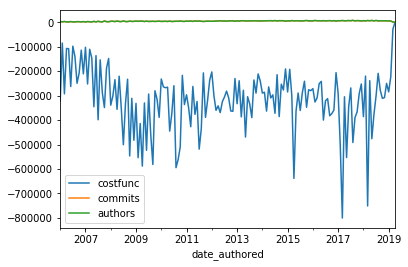

In [136]:
data[(data.index >= '2006-01') & (data.index < '2020-01')].plot()
plt.show()

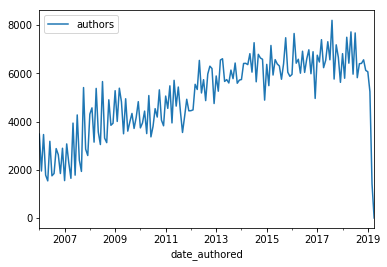

In [137]:
data[(data.index >= '2006-01') & (data.index < '2020-01')][['authors']].plot()
plt.show()

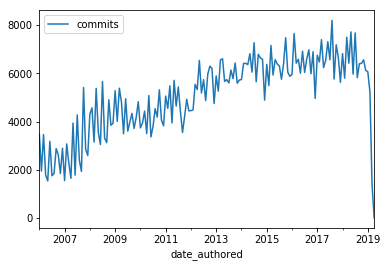

In [138]:
data[(data.index >= '2006-01') & (data.index < '2020-01')][['commits']].plot()
plt.show()

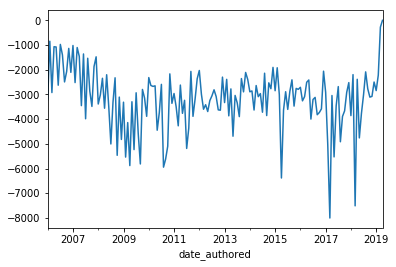

In [142]:
(data[(data.index >= '2006-01') & (data.index < '2020-01')].costfunc / 100).plot()

In [149]:
data['norm_cost'] = data.costfunc / 100
data['norm_authors'] = -data.authors
data['norm_commits'] = -data.commits

/Users/tylerbrown/miniconda3/envs/ds6050/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/tylerbrown/miniconda3/envs/ds6050/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/tylerbrown/miniconda3/envs/ds6050/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

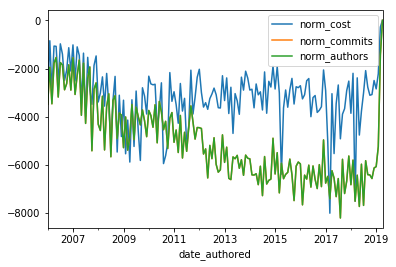

In [150]:

data[(data.index >= '2006-01') & (data.index < '2020-01')][['norm_cost','norm_commits','norm_authors']].plot()
plt.show()